In [175]:
!git add 01_velib.ipynb

In [176]:
!git commit -m "pas mal"

[master 74bdc90] pas mal
 1 file changed, 5072 insertions(+), 4653 deletions(-)


In [190]:
!git checkout -b "refaire_cycliste"

M	01_velib.ipynb
M	Untitled.ipynb
M	cyclistes.csv
M	examples_pandas_et_dataviz.ipynb
Switched to a new branch 'refaire_cycliste'


In [177]:
!git push

Counting objects: 3, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 50.36 KiB | 628.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/romainjouin/formation_python
   90fff1e..74bdc90  master -> master


# Debut

In [461]:
def compare_positions(p1,p2):
    """
    
    """
    test1 = p1.longitude==p2.longitude 
    test2 = p1.lattitude==p2.lattitude 
    return test1 and test2    


In [462]:
def random_float(min=0, max=9):
    import random
    entier = random.randint(min, max)
    float_ = random.random()
    return entier+float_

In [463]:
class Position():
    def __init__(self, longitude, lattitude):
        self.longitude = longitude
        self.lattitude = lattitude
    def __str__(self):
        return "(lon:%.2f lat:%.2f)"%(self.longitude, self.lattitude)


# 1) Logger

In [464]:
class Logger():
    def __init__(self, path, bufferlength=1, separator="\n", mode="a"):
        import os
        if os.path.exists(path) :
            msg = "Attention : vous allez utiliser un fichier existant !"
            print (msg)
            if (mode != "a"):
                raise msg
        self.path         = path
        self.logs         = []
        self.bufferlength = bufferlength
        self.separator    = separator

    def clean_msg(self, msg):
        msg = str(msg)
        if msg[-1] != "\n": 
            msg = msg + "\n"
        return msg
    
    def log(self, msg):
        print(msg)
        msg = self.clean_msg(msg)
        import datetime
        msg=str(datetime.datetime.now().isoformat())+","+msg
        self.logs.append(msg)
        if self.bufferlength < len(self.logs):
            self.write_to_disk()
    
    def write_to_disk(self):
        with open(self.path, "a") as f:
            f.writelines(self.logs)
        self.logs= []
    
    def __del__(self):
        self.write_to_disk()
                

In [465]:
def get_random_position(x_max, y_max):
    return Position(random_float(0, y_max), random_float(0, y_max))

# 2) Velo

In [466]:
class Velo:
    nb_d_instance =0
    def __init__(self):
        import random
        Velo.nb_d_instance += 1
        self.id             = "velo_%s"%(Velo.nb_d_instance)
        self.performance    = random.random()
    def update_performance(self):
        import numpy as np
        self.performance = np.random.normal(0.75, 0.2)

# Velo - test

In [467]:
def test_velo():
    v = Velo()
    perfs = [(v.update_performance(), v.performance)[1] for x in range(10)]
    print(perfs)
test_velo()

[0.6916031946856398, 0.9538870061390927, 0.8459508824651235, 0.8611032277845743, 0.9591892766760434, 0.6130654438096591, 0.8038466077912358, 0.6555242621501156, 0.5238230993687868, 0.46531306888078433]


# 3) Trajet

In [587]:
class Trajet():
    def __init__(self, position_depart, position_arrivee):
        self.depart      = position_depart
        self.destination = position_arrivee
        self.set_position(position_depart)
        self.set_distance() 
        self.avancee_minimale = 0.1
    def __str__(self):
        return "%s -> %s"%(self.depart, self.destination)
        
    def set_position(self, position):
        self.longitude   = position.longitude
        self.lattitude   = position.lattitude
        self.position    = position
        
    def set_pas_old(self, km_h):
        """
        @Todo : ici le point d'arrivée est toujours atteint en 3 temps.
        Il faudrait le rendre dépendant de la distance.
        => rajouter un paramètre de vitesse ? 
        """
        distance_une_minute = km_h / 60
        delta_longitude    = self.destination.longitude  - self.longitude
        delta_lattitude    = self.destination.lattitude  - self.lattitude
        self.pas_longitude = delta_longitude + distance_une_minute
        self.pas_lattitude = delta_lattitude + distance_une_minute
    def set_pas(self, km_h):
        """
        @Todo : ici le point d'arrivée est toujours atteint en 3 temps.
        Il faudrait le rendre dépendant de la distance.
        => rajouter un paramètre de vitesse ? 
        """
        distance_une_minute = km_h / 60
        delta_longitude    = self.destination.longitude  - self.longitude
        delta_lattitude    = self.destination.lattitude  - self.lattitude
        print(delta_longitude, delta_lattitude)
        self.pas_longitude =  delta_longitude-distance_une_minute if delta_longitude!=0 else 0
        self.pas_lattitude =  delta_lattitude-distance_une_minute if delta_lattitude!=0 else 0
        
    def set_distance(self):
        import math
        delta_longitude = self.destination.longitude  - self.longitude
        delta_lattitude = self.destination.lattitude  - self.lattitude
        distance        = math.sqrt(math.pow(delta_longitude, 2) + math.pow(delta_lattitude, 2))
        self.distance   = distance
        print(distance)
        
    def next_position_old(self, km_h=1):
        self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            return self.destination
        else:
            self.set_pas(km_h)
            new_longitude   = self.longitude + self.pas_longitude
            new_latitude    = self.lattitude + self.pas_lattitude
            new_position    = Position(new_longitude, new_latitude)
            self.set_position(new_position)
            return new_position
    def next_position(self, km_h=10):
        self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            return self.destination
        import math
        depart        = self.position
        arrivee       = self.destination
        sur_abscisse  = abs(arrivee.longitude - depart.longitude)
        sur_ordonnees = abs(arrivee.lattitude - depart.lattitude)
        hypothenuse   = math.sqrt(sur_abscisse**2 +sur_ordonnees**2 )
        cosinus       = sur_abscisse / hypothenuse
        sinus         = sur_ordonnees/hypothenuse
        parcours      = km_h / 60
        print("parcours : %s"%parcours)
        if depart.longitude < arrivee.longitude:
            new_abscisse  = depart.longitude + (cosinus * parcours)
        else:
            new_abscisse  = depart.longitude - (cosinus * parcours)
        if depart.lattitude > arrivee.lattitude:
            new_ordonnees = depart.lattitude - (sinus * parcours)
        else:
            new_ordonnees = depart.lattitude + (sinus * parcours)
        new_position  = Position(new_abscisse, new_ordonnees)
        self.set_position(new_position)
        print("new position : %s"%new_position)
        print(self)
        self.set_distance()
        print("distance : %s"%self.distance)
        if self.distance < parcours:
            self.set_position(self.destination)
            return self.destination
        
        return new_position

In [489]:
def test_trajet():
    # de 0,0 a 0,0
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=0,lattitude=0)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    assert (t.distance==0)
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==0)
    assert (t.pas_lattitude==0)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 0,1
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=0,lattitude=1)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    assert (t.distance==1)
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==0)
    #assert (t.pas_lattitude==1/3)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 1,1
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=1,lattitude=1)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    import math
    assert (t.distance==math.sqrt(2))
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==1/3)
    assert (t.pas_lattitude==1/3)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 1,2
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=1,lattitude=2)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    import math
    assert (t.distance==math.sqrt(2*2+1*1))
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==1/3)
    assert (t.pas_lattitude==1/3*2)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
test_trajet()
    

AttributeError: 'Trajet' object has no attribute 'pas_longitude'

# 4) Station

In [470]:
class Station:
    nb_d_instance =0
    station_logger=Logger("./stations.csv")
    def __init__(self, position):
        import random
        Station.nb_d_instance +=1
        NB_BORNES_POSSIBLES = [5,10,15,20,30]
        self.position       = position
        self.nb_bornes      = random.choice(NB_BORNES_POSSIBLES)
        self.velos          = [Velo() for i in range(self.nb_bornes-3)]
        self.id             = Station.nb_d_instance
    def __str__(self):
        to_print = "Station n° {nom} : {position}, {nb_bornes} bornes, {nb_velos_dispo} velos"
        
        return to_print.format(nom=self.id,
                               position=self.position,
                              nb_bornes=self.nb_bornes,
                              nb_velos_dispo=len(self.velos))
    def nb_de_velos(self):
        return len(self.velos)

    def has_empty_place(self):
        return len(self.velos) < self.nb_bornes

    def has_velo(self):
        return 0 < len(self.velos)
    def log(self, message):
        message="station_%s : %s"%(self.id, message)
        Station.station_logger.log(message)
        
    def deposer_un_velo(self, velo):
        if self.has_empty_place():
            velo.update_performance()
            self.velos.append(velo)
            self.log("recupere le velo %s"%velo.id)
            return True
        else:
            self.log("complete")
            return False
    def prendre_un_velo(self):
        if self.has_velo():
            velo = self.velos.pop()
            self.log("donne le velo %s"%velo.id)
            return velo
        else:
            self.log("vide.")
            return False

    def nb_velo_under_perf(self, seuil_de_performance=0.5):
        test = lambda velo: velo.performance < seuil_de_performance
        return len(list(filter(test, self.velos)))
        

Attention : vous allez utiliser un fichier existant !


# 5) Prestataire

In [549]:
class Prestataire():
    def __init__(self, largeur=10, hauteur=10):
        self.largeur = largeur
        self.hauteur = hauteur
        self.reseau = []
        for lattitude in range(self.hauteur):
            for longitude in range(self.largeur):
                emplacement = Position(lattitude, longitude)
                new_station = Station(emplacement)
                self.reseau.append(new_station)
                
    def get_closest_station(self, position):
        """
        @Todo : améliorer pour les valeurs en dehors du réseau
        """
        print(position)
        nb_ligne = round(position.longitude)
        nb_col   = round(position.lattitude)
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        if nb_ligne<0 or nb_col<0:
            return self.reseau[0]
        
        try:
            closest  = self.reseau[int(indice)]
        except:
            closest  = self.reseau[-1]
        return closest
    

    def filtrer_le_reseau(self, function_de_test):
        """
        Renvoie les stations qui passe le test.
        
        Parameters:
            function de test : lambda function
        Return:
            list
        
        """
        return list(filter(function_de_test, self.reseau))
    def nb_station_passant_le_test(self, function):
        r = self.filtrer_le_reseau(function)
        return len(r)
    
    def nombre_de_stations(self):
        return len(self.reseau)
    
    def nombre_de_velos(self):
        return sum(map(lambda x: x.nb_de_velos(),self.reseau))
    
    def nombre_de_stations_pleine(self):
        test  = lambda station: station.nb_bornes == len(station.velos)
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_avec_velo(self):
        test = lambda x: x.has_velo()
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_vide(self):
        test  = lambda station: not station.has_velo()
        return self.nb_station_passant_le_test(test)

    def __str__(self):
        return """
                Nb de stations           : %s 
                Nb de vélos              : %s 
                Nb de stations avec vélo : %s 
                Nb de stations pleines   : %s
                Nb de stations vides     : %s
        """%(self.nombre_de_stations(),
             self.nombre_de_velos(),
             self.nombre_de_stations_avec_velo(),
             self.nombre_de_stations_pleine(),
             self.nombre_de_stations_vide())
    
    def nombre_de_velos_sous_performants(self, seuil=0.5):
        r = map(lambda station: station.nb_velo_under_perf(seuil), self.reseau)
        return sum(list(r))
    def get_topology(self):
        """
        Return a Datframe of longitude/lattitude
        """
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.reseau]}
        
        return pd.DataFrame(infos)
        
        
    

# 4.1) Test decaux

In [472]:
def test_prestataire():
    p = Prestataire(largeur=10, hauteur=10)
    point_minusOne_minusOne = Position(-1,-1)
    point_zero_zero = Position(0,0)
    point_un_un     = Position(1,1)
    point_zero5_zero5     = Position(0.5,0.5)
    point_zero6_zero6     = Position(0.6,0.6)
    point_2_4_3_2     = Position(longitude=2.4,lattitude=3.2)
    point_2_3     = Position(longitude=2,lattitude=3)
    point_9_9     = Position(longitude=9,lattitude=9)
    point_10_10     = Position(longitude=10,lattitude=10)
    print(p.get_closest_station(point_zero_zero).position==Position(0,0))
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_zero_zero).position))
    assert(compare_positions(point_un_un, p.get_closest_station(point_un_un).position))
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_zero5_zero5).position   ))
    assert(compare_positions(point_un_un, p.get_closest_station(point_zero6_zero6).position   ))
    assert(compare_positions(point_2_3, p.get_closest_station(point_2_4_3_2).position       ))
    print(p.get_closest_station(point_10_10).position)
    assert(compare_positions(point_9_9, p.get_closest_station(point_10_10).position       ))    
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_minusOne_minusOne).position       ))        
test_prestataire()

False
(lon:9.00 lat:9.00)


In [473]:
def draw(positions):
    import pandas as pd
    df = pd.DataFrame([ {"lon" : x.longitude, 
                         "lat": x.lattitude} for x in positions])
    df.plot.scatter(x="lon", y="lat")
    
    

In [474]:
r = Prestataire(3,3)

# 6) Villes

In [475]:
class Ville:
    def __init__(self, nb_de_cyclistes, Prestataire):
        self.prestataire = Prestataire
        x_max = Prestataire.largeur -2
        y_max = Prestataire.hauteur-2
        self.cyclistes   = [Cycliste(get_random_position(x_max, y_max), get_random_position(x_max, y_max), self) for i in range(nb_de_cyclistes)]
        self.ax = None
        
    def reveil(self):
        list(map(lambda cycliste : cycliste.avancer(), self.cyclistes))
        
    def get_cycliste_workplaces(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.travail.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.travail.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_cycliste_homes(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.home.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.home.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

        
    def get_cycliste_positions(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.cyclistes],
                  "lattitude"  : [x.position.lattitude for x in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_topology(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.prestataire.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.prestataire.reseau]}
        return pd.DataFrame(infos)
    def get_drawing_data(self):
        cyclistes  = self.get_cycliste_positions()
        stations   = self.get_topology()
        homes      = self.get_cycliste_homes()
        workplaces = self.get_cycliste_workplaces()
        return cyclistes, stations, homes, workplaces

    def draw_map(self,ax=None):
        import matplotlib.pyplot as plt
        cyclistes, stations, homes, workplaces = self.get_drawing_data()
        if not ax:
            ax = stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.4)
        else:
            stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.1, ax=ax)
        homes.plot.scatter(         x="longitudes", y="lattitude", c="green"  , marker="s", ax=ax )
        workplaces.plot.scatter(    x="longitudes", y="lattitude", c="red"    , marker="x", ax=ax )
        cyclistes.plot.scatter(x="longitudes", y="lattitude", c="blue", marker="1"        , ax=ax)
        fig = plt.gcf()
        fig.suptitle(str(cyclistes))
        return ax
        

In [476]:
def test_ville():
    
    p = Prestataire(3,3)
    nb_cyclistes = 2
    v = Ville(nb_cyclistes,p)
    assert(len(v.cyclistes)==nb_cyclistes)

# 7) Cycliste

In [563]:
class Cycliste:
    nb_d_instance =0
    cycliste_logger= Logger("./cyclistes.csv")
    def __init__(self, position_home, position_travail, ville):
        import random
        import numpy as np
        import math
        Cycliste.nb_d_instance +=1
        self.id           = Cycliste.nb_d_instance
        self.home         = position_home
        self.travail      = position_travail
        self.est_en_route = False
        self.position     = position_home
        self.destination  = position_travail
        self.destination_finale = position_travail
        self.sur_velo     = False
        self.velo         = False
        self.sexe         = random.choice(["H", "F"])
        self.age          = random.choice(range(15,85))
        self.nb_pas       = max(2, 2+np.random.normal(2, 2))
        self.ville        = ville
        self.station_home    = self.get_nearest_station(self.home)
        self.station_travail = self.get_nearest_station(self.travail)
        self.set_next_trajet()        
        
        
    def est_a_la_maison(self)        : return self.position == self.home
    def est_au_travail(self)         : return self.position == self.travail
    def est_arrive(self)             : return self.position == self.destination
    def est_sur_station_travail(self): return self.position == self.station_travail.position
    def est_sur_station_home(self)   : return self.position == self.station_home.position

    def ou_suis_je(self):
        if self.est_a_la_maison() : return " a la maison"
        if self.est_au_travail()  : return " au travail"
        if self.est_en_route      : return " en route"
    def ou_vais_je(self):
        if self.destination_finale == self.travail : return " au travail"
        if self.destination_finale == self.home    : return " a la maison"
    
    def log(self, message):
        message="cycliste_%s : %s"%(self.id, message)
        Cycliste.cycliste_logger.log(message)
                
    def get_nearest_station(self, position):
        return self.ville.prestataire.get_closest_station(position)
    
    def est_sur_une_station(self):
        nearest_station = self.get_nearest_station(self.position)
        return compare_positions(nearest_station.position, self.position)
    
    def set_next_trajet(self):
        if self.est_a_la_maison():
            self.log("next trajet = travail")
            self.destination_finale = self.travail
            self.destination        = self.get_nearest_station(self.position).position
            self.trajet             = Trajet(self.position, self.destination)
            #self.trajet.set_pas(nb_pas=3)
        if self.est_sur_station_home():
            self.log("est_sur_station_home")
            if self.destination_finale == self.travail:
                self.log("going to station travail")
                self.trajet = Trajet(self.position, self.station_travail.position)
                #self.trajet.set_pas(nb_pas=3)
            if self.destination_finale == self.home:
                self.log("going to home")
                self.trajet = Trajet(self.position, self.home)
                #self.trajet.set_pas(nb_pas=3)
        if self.est_sur_station_travail():
            self.log("est_sur_station_travail")
            if self.destination_finale == self.travail:
                self.log("going to  travail")
                self.trajet = Trajet(self.position, self.travail)
                #self.trajet.set_pas(nb_pas=3)
            if self.destination_finale == self.home:
                self.log("going to station home")
                self.trajet = Trajet(self.position, self.station_home.position)
                #self.trajet.set_pas(nb_pas=3)
        if self.est_au_travail():
            self.log("est au travail ")            
            self.log("next trajet = maison")
            self.destination_finale = self.home
            self.destination        = self.get_nearest_station(self.position).position
            self.trajet = Trajet(self.position, self.destination)
            #self.trajet.set_pas(nb_pas=3)
            
        if self.est_sur_une_station():
            current_station = self.get_nearest_station(self.position)
            if self.sur_velo:
                self.log(u"est sur velo")
                if current_station.deposer_un_velo(self.velo):
                    self.log(u"A rendu le velo sur %s"%current_station.position)
                    self.sur_velo = False
                    self.velo = False
                else:
                    self.log(u"Ne peut pas déposer de velo sur %s"%current_station.position)
                    next_position = self.position
                    next_position.longitude -=1
                    autre_station = self.get_nearest_station(next_position)
                    self.destination        = autre_station.position
                    self.log(u"Va chercher sur  %s"%autre_station)
            else:
                self.log("n'est pas  sur un  velo")
                velo = current_station.prendre_un_velo()
                if velo:
                    self.log(u"A pris un  velo sur %s"%current_station.position)
                    self.sur_velo = True
                    self.velo = velo
                else:
                    self.log(u"Ne peut pas deposer de velo sur %s"%current_station.position)
                    next_position = self.position
                    next_position.longitude -=1
                    autre_station = self.get_nearest_station(next_position)
                    self.destination        = autre_station.position
                    self.log(u"Va chercher sur  %s"%autre_station)
            
    def avancer(self):
        self.position    = self.trajet.next_position()
        self.set_next_trajet()
        
        

Attention : vous allez utiliser un fichier existant !


In [588]:
p = Prestataire(3,3)
nb_cyclistes = 2
v = Ville(nb_cyclistes,p)

c = Cycliste(Position(0.5,0.6), Position(2.2,2.1), v)
for i in range(30):
    c.avancer()
    print(str(c.position))

c.__dict__

(lon:1.72 lat:1.63)
(lon:1.27 lat:0.88)
cycliste_37 : next trajet = travail
(lon:1.72 lat:1.63)
0.4631873847990648
(lon:1.72 lat:1.63)
(lon:1.20 lat:0.78)
(lon:0.37 lat:0.12)
cycliste_38 : next trajet = travail
(lon:1.20 lat:0.78)
0.2927876930546317
(lon:1.20 lat:0.78)
(lon:0.50 lat:0.60)
(lon:2.20 lat:2.10)
cycliste_39 : next trajet = travail
(lon:0.50 lat:0.60)
0.6403124237432849
(lon:0.50 lat:0.60)
0.6403124237432849
parcours : 0.16666666666666666
new position : (lon:0.37 lat:0.70)
(lon:0.50 lat:0.60) -> (lon:0.00 lat:1.00)
0.4736457570766182
distance : 0.4736457570766182
(lon:0.37 lat:0.70)
(lon:0.37 lat:0.70)
0.4736457570766182
parcours : 0.16666666666666666
new position : (lon:0.24 lat:0.81)
(lon:0.50 lat:0.60) -> (lon:0.00 lat:1.00)
0.3069790904099516
distance : 0.3069790904099516
(lon:0.24 lat:0.81)
(lon:0.24 lat:0.81)
0.3069790904099516
parcours : 0.16666666666666666
new position : (lon:0.11 lat:0.91)
(lon:0.50 lat:0.60) -> (lon:0.00 lat:1.00)
0.14031242374328495
distance : 0.

{'id': 39,
 'home': <__main__.Position at 0x11c2a5908>,
 'travail': <__main__.Position at 0x11c2a66d8>,
 'est_en_route': False,
 'position': <__main__.Position at 0x11c2a65c0>,
 'destination': <__main__.Position at 0x11c2a6080>,
 'destination_finale': <__main__.Position at 0x11c2a5908>,
 'sur_velo': True,
 'velo': <__main__.Velo at 0x11c2a5f60>,
 'sexe': 'F',
 'age': 75,
 'nb_pas': 4.427025888643332,
 'ville': <__main__.Ville at 0x11c2a64a8>,
 'station_home': <__main__.Station at 0x11c2a5e48>,
 'station_travail': <__main__.Station at 0x11c2a60b8>,
 'trajet': <__main__.Trajet at 0x11c2a6780>}

In [544]:
import math
depart        = Position(2,3)
arrivee       = Position(4,6)
sur_abscisse  = abs(arrivee.longitude - depart.longitude)
sur_ordonnees = abs(arrivee.lattitude - depart.lattitude)
hypothenuse   = math.sqrt(sur_abscisse**2 +sur_ordonnees**2 )
cosinus       = sur_abscisse / hypothenuse
sinus         = sur_ordonnees/hypothenuse
parcours      = vitesse
new_abscisse  = depart.longitude + cosinus * parcours
new_ordonnees = depart.lattitude +sinus * parcours
return new_ordonnees, new_abscisse

SyntaxError: 'return' outside function (<ipython-input-544-7bc0f888da34>, line 12)

# 7) Algo

In [512]:
!rm cyclistes.csv


                Nb de stations           : 9 
                Nb de vélos              : 190 
                Nb de stations avec vélo : 9 
                Nb de stations pleines   : 9
                Nb de stations vides     : 0
        


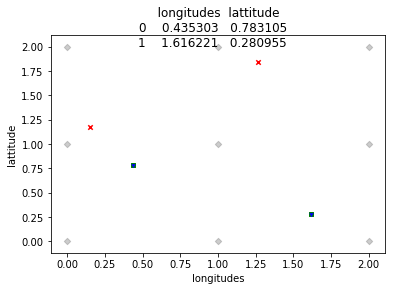

In [513]:
JcDecaux = Prestataire(3,3)
print(JcDecaux)
paris = Ville(2, JcDecaux)
paris.draw_map()

In [514]:
!cat cyclistes.csv

2018-10-20T00:01:07.196570,cycliste_1 : next trajet = travail
2018-10-20T00:01:07.196715,cycliste_2 : next trajet = travail


current = (lon:0.44 lat:0.78), next =(lon:0.62 lat:0.52), est_arrive=False, trajet=(lon:0.44 lat:0.78) -> (lon:1.00 lat:0.00)
current = (lon:0.81 lat:0.26), next =(lon:0.54 lat:0.51), est_arrive=False, trajet=(lon:0.81 lat:0.26) -> (lon:0.00 lat:1.00)
current = (lon:0.27 lat:0.75), next =(lon:0.51 lat:0.50), est_arrive=False, trajet=(lon:0.27 lat:0.75) -> (lon:1.00 lat:0.00)
current = (lon:0.76 lat:0.25), next =(lon:0.50 lat:0.50), est_arrive=False, trajet=(lon:0.76 lat:0.25) -> (lon:0.00 lat:1.00)
current = (lon:0.25 lat:0.75), next =(lon:0.50 lat:0.50), est_arrive=False, trajet=(lon:0.25 lat:0.75) -> (lon:1.00 lat:0.00)
current = (lon:0.75 lat:0.25), next =(lon:0.50 lat:0.50), est_arrive=False, trajet=(lon:0.75 lat:0.25) -> (lon:0.00 lat:1.00)
current = (lon:0.25 lat:0.75), next =(lon:0.50 lat:0.50), est_arrive=False, trajet=(lon:0.25 lat:0.75) -> (lon:1.00 lat:0.00)
current = (lon:0.75 lat:0.25), next =(lon:0.50 lat:0.50), est_arrive=False, trajet=(lon:0.75 lat:0.25) -> (lon:0.00 la

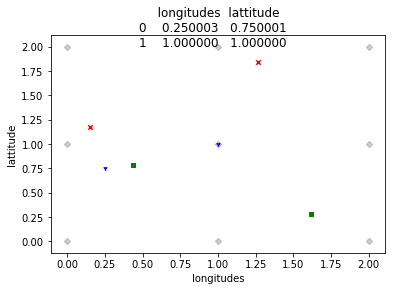

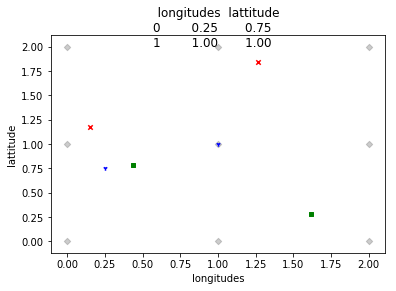

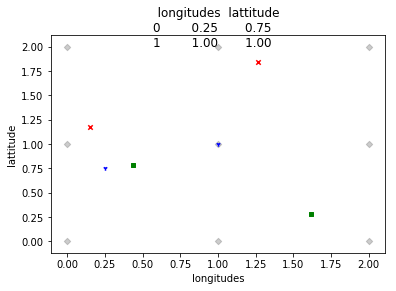

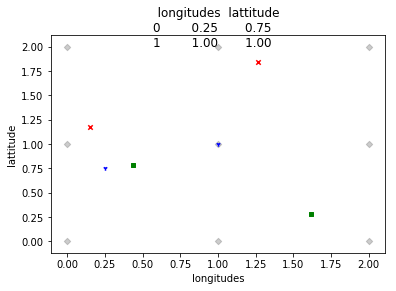

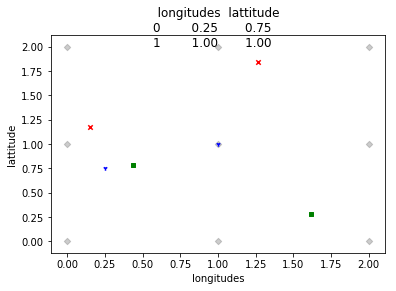

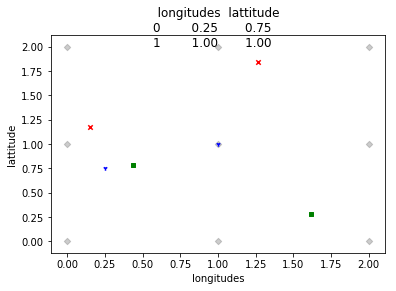

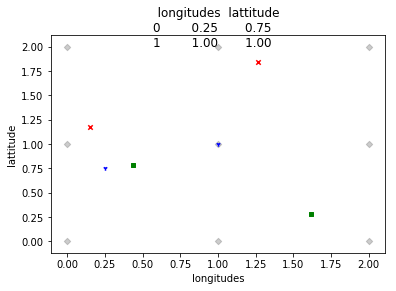

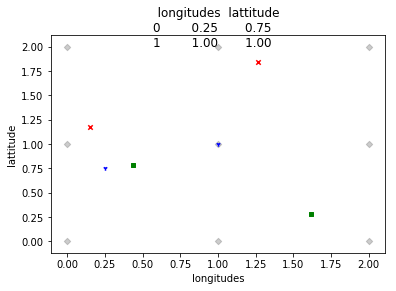

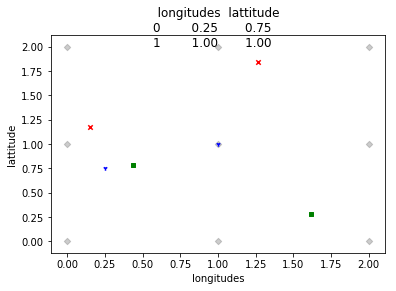

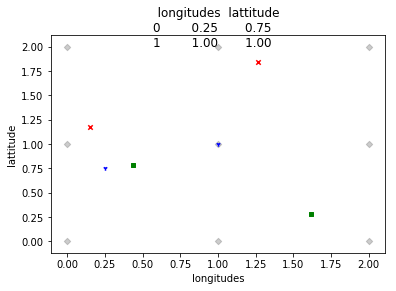

In [515]:
r = {}
for i in range(10):
    paris.reveil()
    paris.draw_map()
    

In [516]:
import pandas as pd

In [390]:
for i in r[j]:
    print(i)

   longitudes  lattitude
0    0.143928   0.434728
1    0.000000   0.000000
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172


In [391]:
type(i)

pandas.core.frame.DataFrame

   longitudes  lattitude
0    0.834931    0.09461
1    0.000000    0.00000
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0    1.000000   0.000000
1    0.806579   0.585172
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0           0          1
1           1          1
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude


/Users/romain/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0    0.000000   1.000000
1    0.266494   0.079486
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0           1          0
1           0          0
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude


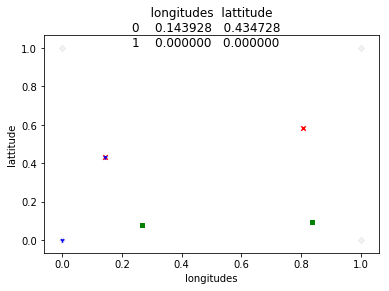

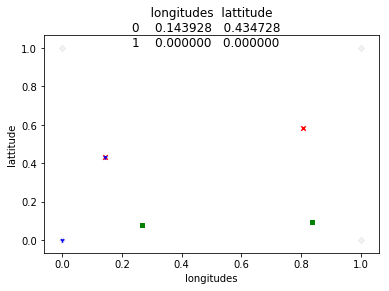

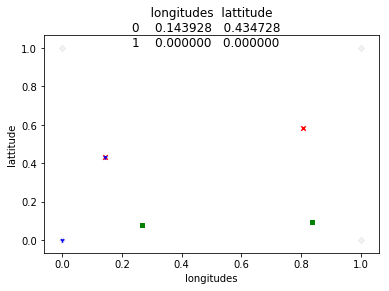

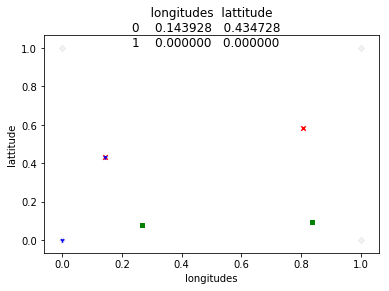

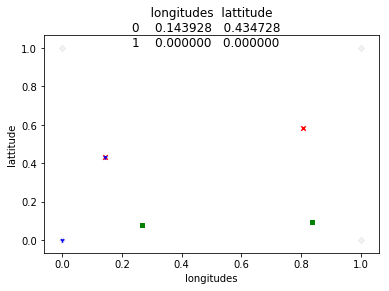

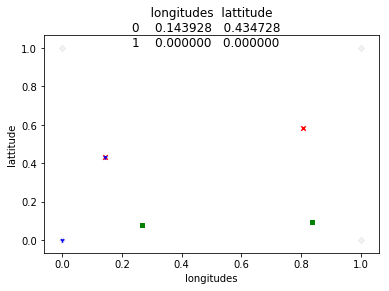

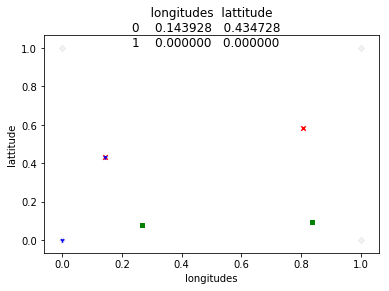

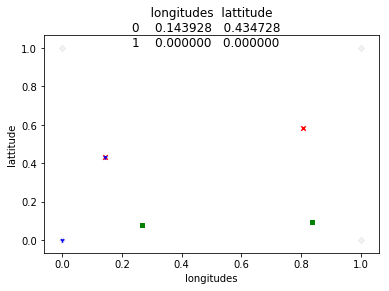

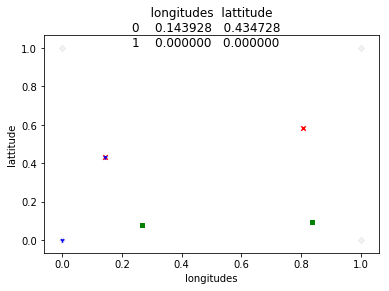

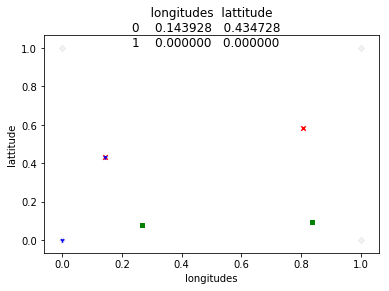

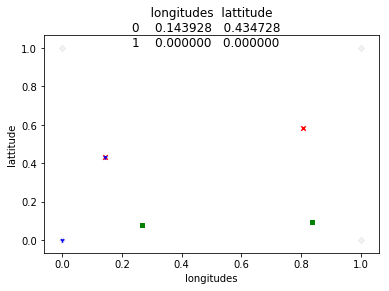

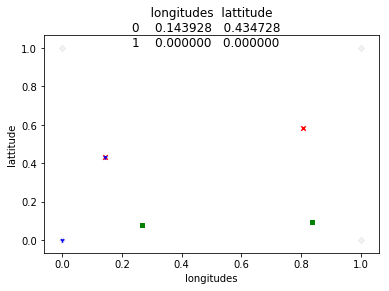

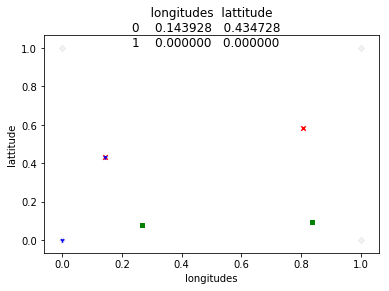

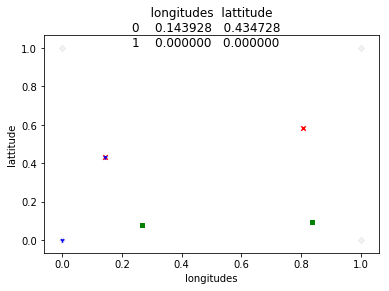

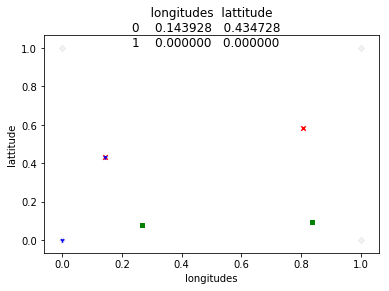

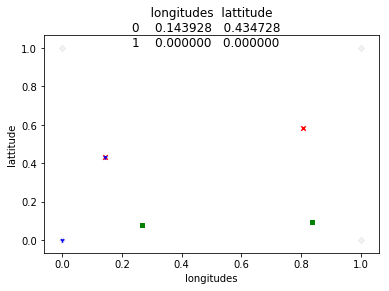

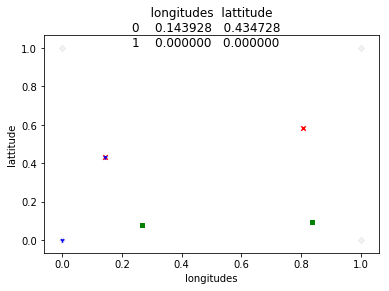

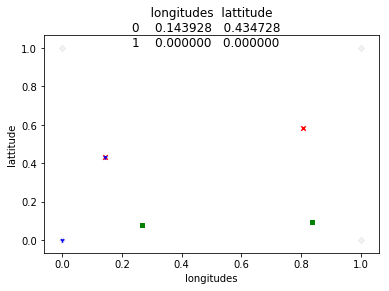

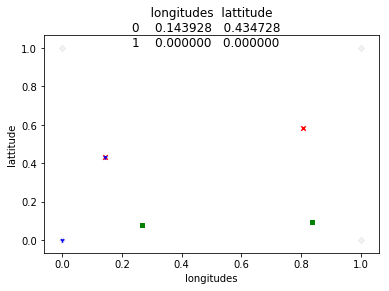

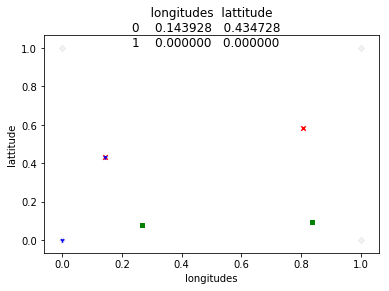

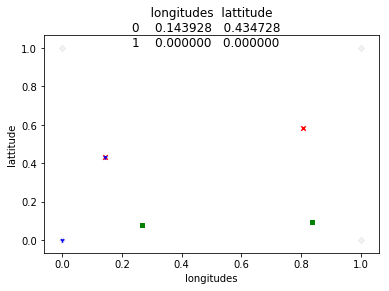

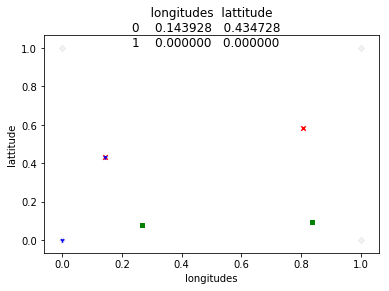

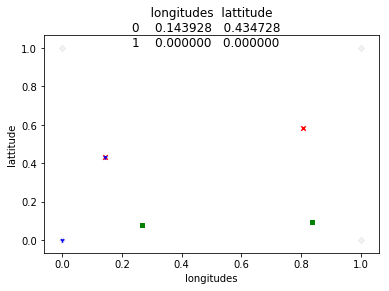

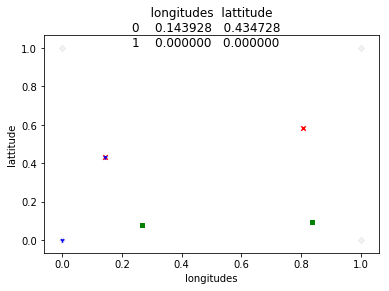

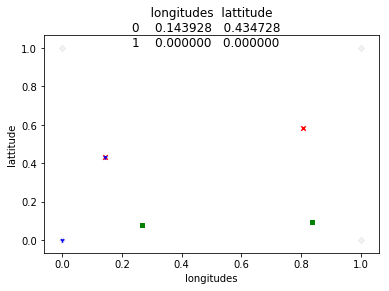

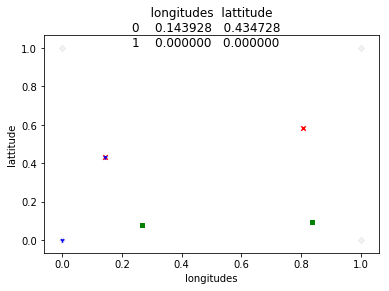

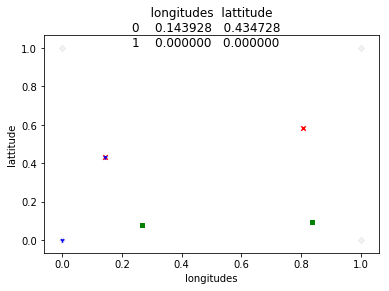

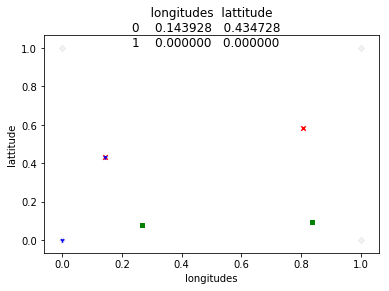

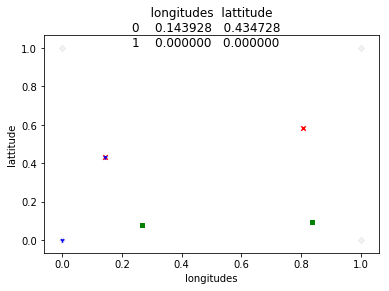

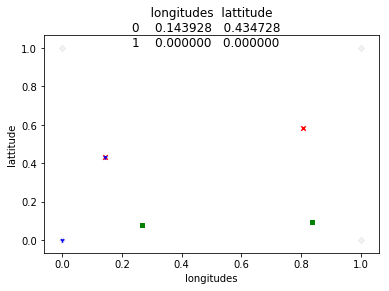

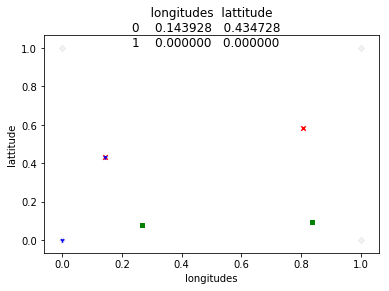

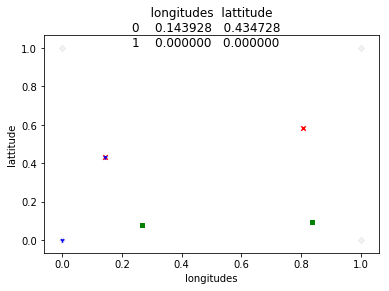

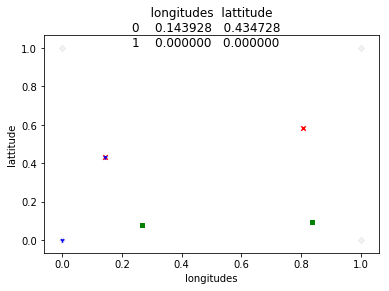

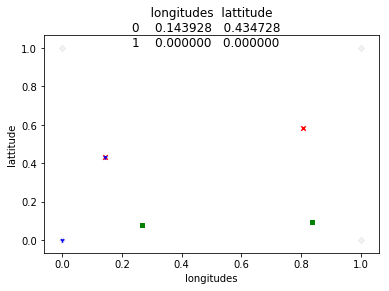

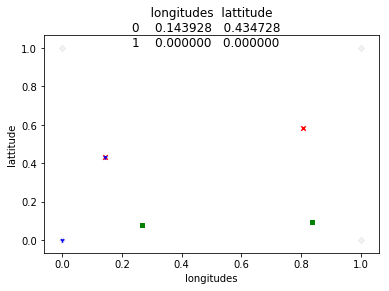

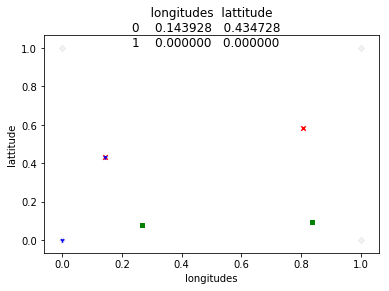

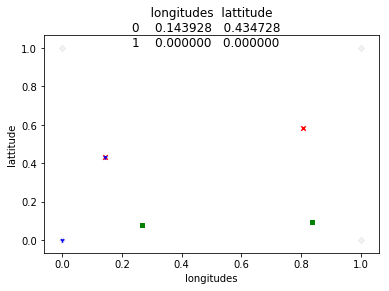

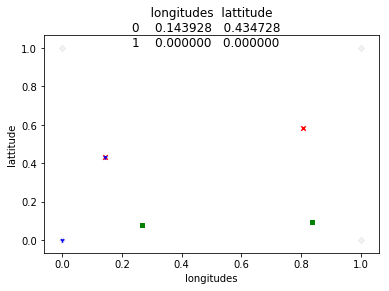

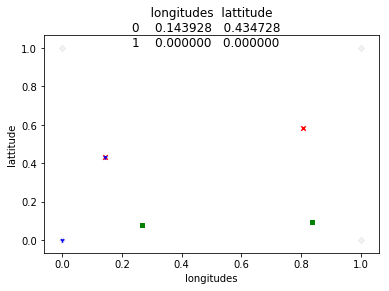

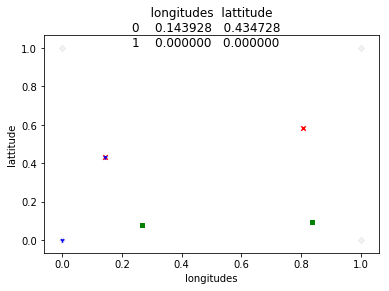

In [395]:
ax = False
for i, j in enumerate(r):
    for a in r[j]:
        print(a)
        if not ax:
            ax=paris.draw_map()
            #ax = a.plot.scatter(x="longitudes", y="lattitude")
        else:
            paris.draw_map(ax)
            a.plot.scatter(x="longitudes", y="lattitude", ax=ax)

,longitudes,lattitude
0,6.390485,8.044468
1,0.516143,4.117503
2,7.739245,7.839961


In [311]:
if False:
    path_to_cyclistes = "./cyclistes.csv"
    logger_ = Logger(path_to_cyclistes)
    infos_voulues = ["id", "sexe", "sportivite", "age", "sur_velo"]
    to_write      = ",".join(infos_voulues)
    logger_.log(to_write)
    for cycliste in paris.cyclistes:
        dico          = cycliste.__dict__        
        infos         = [str(dico[voulue]) for voulue in infos_voulues]
        to_write      = ",".join(infos)
        logger_.log(to_write)


Attention : vous allez utiliser un fichier existant !


# Exemple de dataFrame pandas

In [313]:
logger_.write_to_disk()


In [308]:
import pandas as pd

In [309]:
dico = {}
for i in range(12):
    seuil       = float(i/10)
    nb_velo     = test_reseau.nombre_de_velos_sous_performants(seuil)
    dico[seuil] = nb_velo

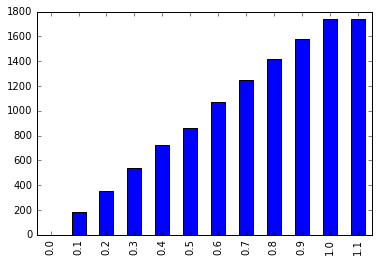

In [310]:
%matplotlib inline
pd.DataFrame(dico, index=range(12)).T[0].plot(kind='bar')